In [200]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  av.io import read
import pandas as pd
import datetime
import tensorflow as tf
#tf.enable_eager_execution()


from sklearn.preprocessing import normalize
from tensorflow import keras



In [267]:
use_rotation_sensor = False
if use_rotation_sensor:
    cut_shape = (100, 8)
    normalize_vector = np.array([1,1,1,1,1, 15, 15, 15])
else:
    cut_shape = (100, 3)
    normalize_vector = np.array([15, 15, 15])
gestures = {0: 'Noise', 1: 'Left', 2: 'Right'}

In [253]:
def read_file(filename, lable=None):
    data, meta = read(" ".join(["a:" + str(i) for i in range(4)]), filename, 50)
    datapairs = list(zip(data, meta))
    
    df = pd.DataFrame()
    names = []
    col_name_tpls = []
    for sensor_data, stream_object in datapairs:
        meta_dict = stream_object.metadata
        # print(meta_dict)
        name = meta_dict["NAME"]
        names.append(name)
        n_cols = len(sensor_data)
        col_names = []
        for i in range(n_cols):
            col_name = name + "_" + str(i)
            col_names.append(col_name)
            df[col_name] = pd.Series(sensor_data.T[:,i])
        col_name_tpls.append(col_names)
    df.index = pd.TimedeltaIndex(freq="20ms", start=0.0, periods=len(df))
    return df, col_name_tpls

def trim_data(data_frame, start=0.0, end=None):
    if end:
        df = data_frame[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = data_frame[pd.Timedelta(10**9 * start):]
    return df

def cut_data(data_frame, cuts):
    df_cut_list = np.ndarray(shape=(len(cuts),) + cut_shape)
    for i, cut in enumerate(cuts):
        df_i = data_frame[pd.Timedelta(10**9 * cut[0]):pd.Timedelta(10**9 * cut[1])]
        start_chanel = 0
        if not use_rotation_sensor:
            start_chanel = 5
        df_cut_list[i, : , :] = df_i.iloc[0: 100, start_chanel:8]
    return df_cut_list


def find_peaks(df, sensor, start=0.0, end=None, sel_method="right"):
    peaks = []
    if end:
        df = df[pd.Timedelta(10**9 * start):pd.Timedelta(10**9 * end)]
    else:
        df = df[pd.Timedelta(10**9 * start):]

    for i in df.index:
        value = df[sensor][i]
        if sel_method == "right":
            cond = value > 8
        elif sel_method == "left":
            cond = value < -1
        if cond:
            new = True
            for peak in peaks:
                if i - pd.Timedelta(10**9) < peak + pd.Timedelta(10**9):
                    new = False
                    break
            if new:
                peaks.append(i)
    cuts = []
    for peak in peaks:
        t = peak.value / 10 ** 9
        cuts.append((t-1, t+1))
    return cuts 

def normalize_cuts(cuts):
    for i in range(len(cuts)):
        cuts[i, : , :] = cuts[i]/normalize_vector
    return cuts
  

def plot_dataframe(df, col_name_tpls):
    for col_name_tpl in col_name_tpls:
        for col_name in col_name_tpl:
            fig = df[col_name].plot()
            fig.set_title(col_name)
            plt.show()

def plot_cuts(cuts, sensor=None):
    if sensor is None:
        for cut in cuts:
            plt.plot(cut)
            plt.show()
        return
    for cut in cuts:
        cut = cut[sensor]
        cut = cut.values.reshape(-1,1)
        print(cut.shape)
        normed_matrix = normalize(cut, axis=0, norm='l1')
        plt.plot(normed_matrix)
        plt.show()

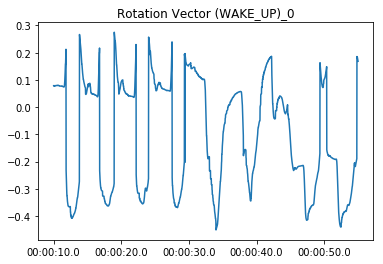

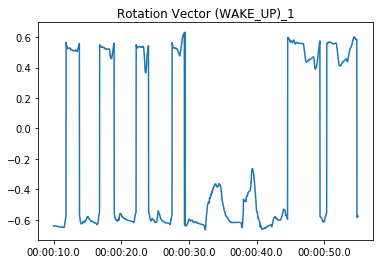

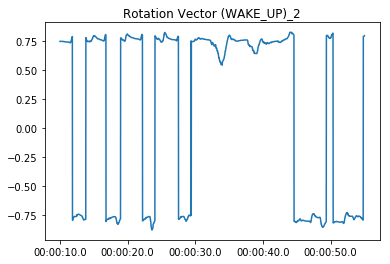

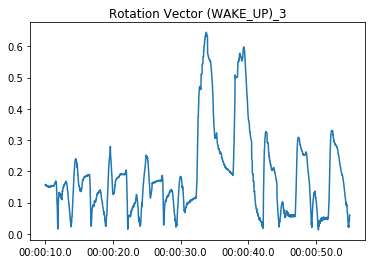

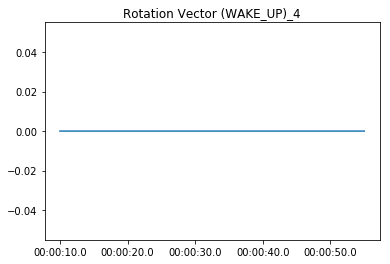

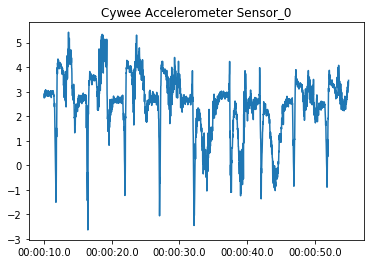

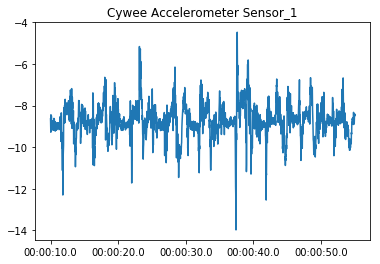

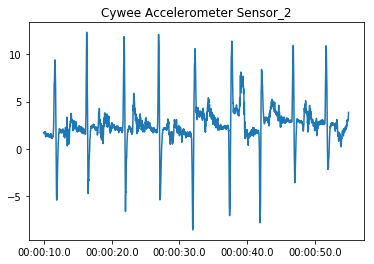

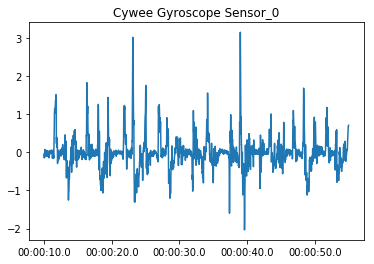

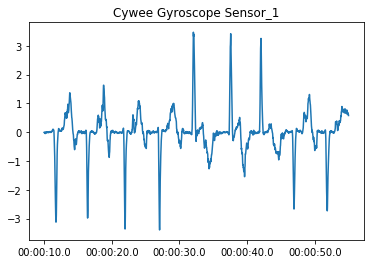

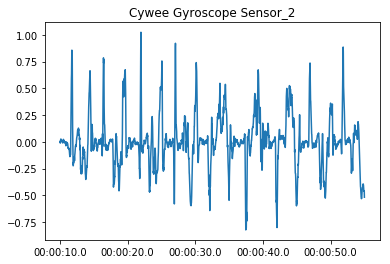

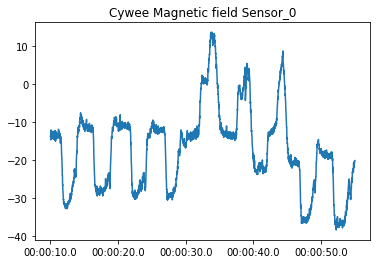

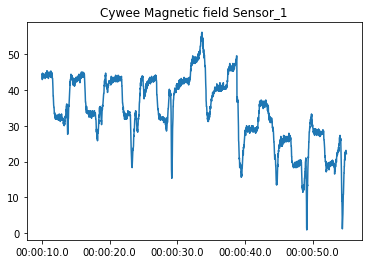

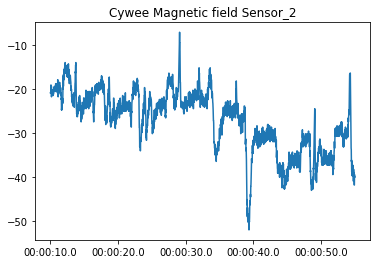

9 : [(10.54, 12.54), (15.239999999999998, 17.24), (20.76, 22.76), (25.86, 27.86), (31.22, 33.22), (36.64, 38.64), (41.14, 43.14), (45.74, 47.74), (50.64, 52.64)]
Found cuts: 9


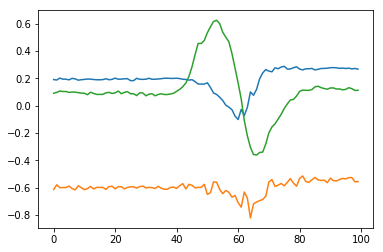

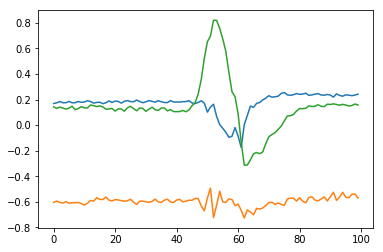

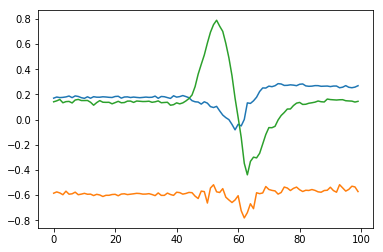

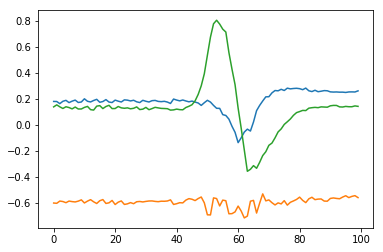

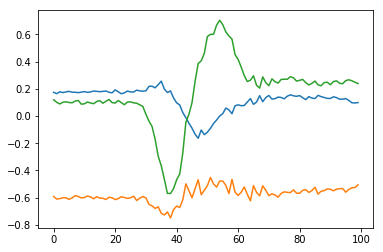

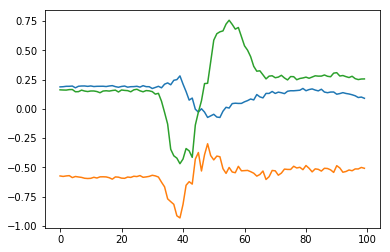

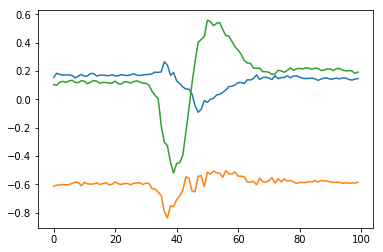

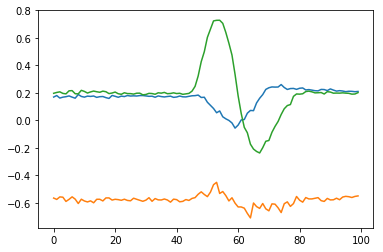

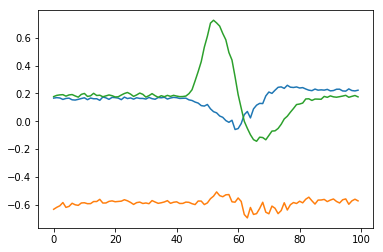

In [256]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
plot_dataframe(trimed_df, col_name_tpls)
peaks = find_peaks(trimed_df, "Cywee Accelerometer Sensor_2")
print(len(peaks), ":", peaks)
cuts = normalize_cuts(cut_data(trimed_df, peaks))
print("Found cuts:", len(cuts))
plot_cuts(cuts)

In [272]:
def  learn_clisifyer(data, lables):
    print(data.shape)
    model = keras.Sequential([
        #keras.layers.Flatten(),
        keras.layers.Flatten(input_shape=cut_shape),
        keras.layers.Dense(100 * len(normalize_vector), activation=tf.nn.relu),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    model.fit(data, lables, epochs=50)
    test_loss, test_acc = model.evaluate(data, lables)

    print('Test accuracy:', test_acc)
    
    return model

    



In [235]:
def prepare_learn_set(data_frame, previous_learned_data=None):
    peaks = find_peaks(data_frame, "Cywee Accelerometer Sensor_2")
    cuts = cut_data(data_frame, peaks)
    learn_data = normalize_cuts(cuts) # Normalize
    print("DataShape:", learn_data.shape)
    
    if previous_learned_data is not None:
        learn_data = np.append(learn_data, previous_learned_data, axis=0)
    return learn_data
    
    

# Use Tensorflow to classify gestures

## Learn model


In [270]:
df, col_name_tpls = read_file("swipe_right_10_new.mkv")
trimed_df = trim_data(df, 52, 90)
learn_data_r = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("swipe_left_10.mkv")
trimed_df = trim_data(df, 10, 57)
learn_data_l = prepare_learn_set(trimed_df)

df, col_name_tpls = read_file("data/swipe_left_20.mkv")
trimed_df = trim_data(df, 15, 90)
learn_data_l = prepare_learn_set(trimed_df, learn_data_l)

df, col_name_tpls = read_file("random_noise.mkv")
trimed_df = trim_data(df, 0)
cuts = cut_data(trimed_df, [(i * 2, i*2+2) for i in range(50)])
learn_data_noise = normalize_cuts(cuts)
print("Noiseshape:", learn_data_noise.shape)
print("Learn L shape:", learn_data_l.shape)

learn_data = np.append(learn_data_noise, learn_data_l, axis=0)
learn_data = np.append(learn_data, learn_data_r, axis=0)

lables = [0]*len(learn_data_noise) + [1]*len(learn_data_l) + [2]*len(learn_data_r)

print("Learn data has shape: {}".format(learn_data.shape))
model = learn_clisifyer(learn_data, lables)


DataShape: (9, 100, 3)
DataShape: (9, 100, 3)
DataShape: (18, 100, 3)
Noiseshape: (50, 100, 3)
Learn L shape: (27, 100, 3)
Learn data has shape: (86, 100, 3)
(86, 100, 3)
Epoch 1/500
86/86 [==============================] - 0s 5ms/sample - loss: 0.8023 - acc: 0.6977
Epoch 2/500
86/86 [==============================] - 0s 160us/sample - loss: 0.5070 - acc: 0.7907
Epoch 3/500
86/86 [==============================] - 0s 260us/sample - loss: 0.3955 - acc: 0.8256
Epoch 4/500
86/86 [==============================] - 0s 139us/sample - loss: 0.3060 - acc: 0.9419
Epoch 5/500
86/86 [==============================] - 0s 261us/sample - loss: 0.2742 - acc: 0.9419
Epoch 6/500
86/86 [==============================] - 0s 214us/sample - loss: 0.2189 - acc: 0.9419
Epoch 7/500
86/86 [==============================] - 0s 211us/sample - loss: 0.1894 - acc: 0.9419
Epoch 8/500
86/86 [==============================] - 0s 190us/sample - loss: 0.1578 - acc: 0.9535
Epoch 9/500
86/86 [============================

86/86 [==============================] - 0s 140us/sample - loss: 0.0019 - acc: 1.0000
Epoch 83/500
86/86 [==============================] - 0s 239us/sample - loss: 0.0018 - acc: 1.0000
Epoch 84/500
86/86 [==============================] - 0s 146us/sample - loss: 0.0018 - acc: 1.0000
Epoch 85/500
86/86 [==============================] - 0s 136us/sample - loss: 0.0018 - acc: 1.0000
Epoch 86/500
86/86 [==============================] - 0s 130us/sample - loss: 0.0017 - acc: 1.0000
Epoch 87/500
86/86 [==============================] - 0s 137us/sample - loss: 0.0017 - acc: 1.0000
Epoch 88/500
86/86 [==============================] - 0s 159us/sample - loss: 0.0017 - acc: 1.0000
Epoch 89/500
86/86 [==============================] - 0s 132us/sample - loss: 0.0016 - acc: 1.0000
Epoch 90/500
86/86 [==============================] - 0s 137us/sample - loss: 0.0016 - acc: 1.0000
Epoch 91/500
86/86 [==============================] - 0s 139us/sample - loss: 0.0016 - acc: 1.0000
Epoch 92/500
86/86 [===

86/86 [==============================] - 0s 165us/sample - loss: 5.1553e-04 - acc: 1.0000
Epoch 163/500
86/86 [==============================] - 0s 143us/sample - loss: 5.0965e-04 - acc: 1.0000
Epoch 164/500
86/86 [==============================] - 0s 187us/sample - loss: 5.0402e-04 - acc: 1.0000
Epoch 165/500
86/86 [==============================] - 0s 171us/sample - loss: 4.9743e-04 - acc: 1.0000
Epoch 166/500
86/86 [==============================] - 0s 140us/sample - loss: 4.9216e-04 - acc: 1.0000
Epoch 167/500
86/86 [==============================] - 0s 179us/sample - loss: 4.8612e-04 - acc: 1.0000
Epoch 168/500
86/86 [==============================] - 0s 142us/sample - loss: 4.8128e-04 - acc: 1.0000
Epoch 169/500
86/86 [==============================] - 0s 159us/sample - loss: 4.7596e-04 - acc: 1.0000
Epoch 170/500
86/86 [==============================] - 0s 146us/sample - loss: 4.7038e-04 - acc: 1.0000
Epoch 171/500
86/86 [==============================] - 0s 166us/sample - loss:

86/86 [==============================] - 0s 181us/sample - loss: 2.3714e-04 - acc: 1.0000
Epoch 241/500
86/86 [==============================] - 0s 146us/sample - loss: 2.3533e-04 - acc: 1.0000
Epoch 242/500
86/86 [==============================] - 0s 165us/sample - loss: 2.3310e-04 - acc: 1.0000
Epoch 243/500
86/86 [==============================] - 0s 131us/sample - loss: 2.3124e-04 - acc: 1.0000
Epoch 244/500
86/86 [==============================] - 0s 147us/sample - loss: 2.2911e-04 - acc: 1.0000
Epoch 245/500
86/86 [==============================] - 0s 147us/sample - loss: 2.2764e-04 - acc: 1.0000
Epoch 246/500
86/86 [==============================] - 0s 133us/sample - loss: 2.2571e-04 - acc: 1.0000
Epoch 247/500
86/86 [==============================] - 0s 157us/sample - loss: 2.2352e-04 - acc: 1.0000
Epoch 248/500
86/86 [==============================] - 0s 129us/sample - loss: 2.2174e-04 - acc: 1.0000
Epoch 249/500
86/86 [==============================] - 0s 129us/sample - loss:

86/86 [==============================] - 0s 146us/sample - loss: 1.3435e-04 - acc: 1.0000
Epoch 319/500
86/86 [==============================] - 0s 153us/sample - loss: 1.3352e-04 - acc: 1.0000
Epoch 320/500
86/86 [==============================] - 0s 137us/sample - loss: 1.3282e-04 - acc: 1.0000
Epoch 321/500
86/86 [==============================] - 0s 155us/sample - loss: 1.3195e-04 - acc: 1.0000
Epoch 322/500
86/86 [==============================] - 0s 142us/sample - loss: 1.3108e-04 - acc: 1.0000
Epoch 323/500
86/86 [==============================] - 0s 125us/sample - loss: 1.3032e-04 - acc: 1.0000
Epoch 324/500
86/86 [==============================] - 0s 137us/sample - loss: 1.2954e-04 - acc: 1.0000
Epoch 325/500
86/86 [==============================] - 0s 130us/sample - loss: 1.2864e-04 - acc: 1.0000
Epoch 326/500
86/86 [==============================] - 0s 140us/sample - loss: 1.2783e-04 - acc: 1.0000
Epoch 327/500
86/86 [==============================] - 0s 138us/sample - loss:

86/86 [==============================] - 0s 165us/sample - loss: 8.5675e-05 - acc: 1.0000
Epoch 397/500
86/86 [==============================] - 0s 130us/sample - loss: 8.5218e-05 - acc: 1.0000
Epoch 398/500
86/86 [==============================] - 0s 152us/sample - loss: 8.4864e-05 - acc: 1.0000
Epoch 399/500
86/86 [==============================] - 0s 147us/sample - loss: 8.4358e-05 - acc: 1.0000
Epoch 400/500
86/86 [==============================] - 0s 137us/sample - loss: 8.4013e-05 - acc: 1.0000
Epoch 401/500
86/86 [==============================] - 0s 163us/sample - loss: 8.3578e-05 - acc: 1.0000
Epoch 402/500
86/86 [==============================] - 0s 126us/sample - loss: 8.3060e-05 - acc: 1.0000
Epoch 403/500
86/86 [==============================] - 0s 130us/sample - loss: 8.2626e-05 - acc: 1.0000
Epoch 404/500
86/86 [==============================] - 0s 124us/sample - loss: 8.2210e-05 - acc: 1.0000
Epoch 405/500
86/86 [==============================] - 0s 118us/sample - loss:

86/86 [==============================] - 0s 133us/sample - loss: 5.8938e-05 - acc: 1.0000
Epoch 475/500
86/86 [==============================] - 0s 148us/sample - loss: 5.8586e-05 - acc: 1.0000
Epoch 476/500
86/86 [==============================] - 0s 153us/sample - loss: 5.8342e-05 - acc: 1.0000
Epoch 477/500
86/86 [==============================] - 0s 179us/sample - loss: 5.8120e-05 - acc: 1.0000
Epoch 478/500
86/86 [==============================] - 0s 151us/sample - loss: 5.7835e-05 - acc: 1.0000
Epoch 479/500
86/86 [==============================] - 0s 165us/sample - loss: 5.7566e-05 - acc: 1.0000
Epoch 480/500
86/86 [==============================] - 0s 126us/sample - loss: 5.7363e-05 - acc: 1.0000
Epoch 481/500
86/86 [==============================] - 0s 146us/sample - loss: 5.7049e-05 - acc: 1.0000
Epoch 482/500
86/86 [==============================] - 0s 131us/sample - loss: 5.6792e-05 - acc: 1.0000
Epoch 483/500
86/86 [==============================] - 0s 127us/sample - loss:

# Test learned model
Test data has gestures:
Left, Left, Left, Left, Right, Right, Right, Left, Left

In [271]:
df, col_name_tpls = read_file("swipe_test_both.mkv")
trimed_df = trim_data(df, 10, 55)
test_data = prepare_learn_set(trimed_df) 
test_lables = [1, 1, 1, 1, 2, 2, 2, 1, 1]

predictions = model.predict(test_data)
print('Predicted:')
for i, p in enumerate(predictions):
    print('{}: {} should be {} -> {}'.format(i, gestures[np.argmax(p)], 
                                         gestures[test_lables[i]], np.argmax(p) == test_lables[i]))

print('\nTest if noise will be predicted as noise')
df, col_name_tpls = read_file("data/noise_test.mkv")
trimed_df = trim_data(df, 16, 88)
learn_data_noise = prepare_learn_set(trimed_df)
for p in model.predict(learn_data_noise):
    print(gestures[np.argmax(p)])

DataShape: (9, 100, 3)
Predicted:
0: Left should be Left -> True
1: Left should be Left -> True
2: Left should be Left -> True
3: Left should be Left -> True
4: Right should be Right -> True
5: Right should be Right -> True
6: Right should be Right -> True
7: Left should be Left -> True
8: Left should be Left -> True

Test if noise will be predicted as noise
DataShape: (18, 100, 3)
Left
Noise
Left
Left
Noise
Left
Left
Left
Left
Left
Left
Noise
Left
Noise
Noise
Left
Left
Left
